In [1]:
def clustered_permutation_importance(clf,X,y,clusters,scoring, n_repeats): 
    """
    clf: fitted classifier
    X
    y
    clusters: (dict)
    scoring: 'acc','f1','auc'
    """
    from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

    scr_before, scr_after = pd.Series(), pd.DataFrame(columns=clusters.keys()) 
    for i in range(n_repeats):
        prob=clf.predict_proba(X)[:,1]
        pred=clf.predict(X)
        if scoring == 'auc':
            scr_before.loc[i]=roc_auc_score(y, prob)
        elif scoring == 'f1':
            scr_before.loc[i]=f1_score(y, pred)
        elif scoring == 'acc':
            scr_before.loc[i]=accuracy_score(y, pred)
            
        for  j  in  scr_after.columns:
            X_=X.copy(deep=True) 
            for  k  in  clusters[j]:
                np.random.shuffle(X_[k].values)  #  shufﬂe  cluster 
            prob2=clf.predict_proba(X_)[:,1]
            pred2=clf.predict(X_)
            if scoring == 'auc':
                scr_after.loc[i,j]=roc_auc_score(y, prob2)
            elif scoring == 'acc':
                scr_after.loc[i,j]=accuracy_score(y, pred2)
            elif scoring == 'f1':
                scr_after.loc[i,j]=f1_score(y, pred2)
    imp=(-1*scr_after).add(scr_before,axis=0)
    imp=imp/(1-scr_after).replace(0, np.nan)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    imp.index = ['Cluster {}'.format(j) for j in scr_after.columns]
    imp.replace([-np.inf, np.nan], 0, inplace=True)
    return  imp

Feature Selection
- Input
    - label(y): 1,5,20 day price direction
    - periods : 2012-2022
    - features: TA, Net-purchase(SMA5),  Macro-variable(pct change)

- Model: RF (comparing with Logistic regression)
    - Feature Analysis Methods: 
        1. Feature clustering: Hierarchical Clustering - Spearman Correlation
        2. Permutation Importance (Accuracy, F1-score, AUC score) analysis

- Output
    - Performances
    - Feature cluster importance for each label and each score

In [2]:
# libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('tableau-colorblind10')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score

# Feature Importance / Clustering
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
market_df = pd.read_csv('C:data/initial_data.csv')
market_df = market_df.rename(columns={market_df.columns[0]:'Date'})
market_df.index = pd.to_datetime(market_df.Date)
market_df.drop(columns='Date',inplace=True)
market_df.dropna(inplace=True)

feature_df = pd.read_csv('C:data/features.csv')
feature_df = feature_df.rename(columns={feature_df.columns[0]:'Date'})
feature_df.index = pd.to_datetime(feature_df.Date)
feature_df.drop(columns='Date',inplace=True)
feature_df.dropna(inplace=True)

In [5]:
X_ = feature_df.dropna()['2012':'2021']

In [6]:
# without net puchase info
#X_ =X_.drop(columns=['institutions SMA5', 'individuals SMA5','foreigners SMA5'])

In [7]:
len(X_[:'2018']),len(X_['2018':])

(1665, 956)

In [8]:
X_[:'2018']

,Trend ADX(14),Trend ADX(28),Trend DPO(20),Trend DPO(40),"Trend MACD (26,12)","Trend MACD (52,24)","Trend MACD_Diff (26,12,9)","Trend MACD_Diff (52,24,18)",Trend RSI(14),Trend RSI(28),...,institutions SMA5,individuals SMA5,foreigners SMA5,crude oil %Change,gold %Change,natural gas %Change,USD/KRW %Change,EUR/KRW %Change,JPY/KRW %Change,CNY/KRW %Change
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,18.304436,15.850374,-13.7645,61.09000,-4.619306,-4.589233,0.912873,-2.093932,54.302228,51.486401,...,1.651332e+11,-2.175586e+11,6.784662e+10,-0.008229,0.016819,-0.012554,-0.011689,-0.003479,-0.008205,-0.011727
2012-01-04,17.247912,15.636684,-74.9645,68.87300,-2.614976,-3.713112,2.333763,-1.089621,52.672905,50.802488,...,1.587162e+11,-2.541277e+11,1.063361e+11,0.041789,0.021650,0.001338,0.002313,-0.005786,0.002115,0.002252
2012-01-05,16.421240,15.462854,-56.0505,49.88775,-1.209287,-3.028187,2.991562,-0.362096,52.217574,50.614335,...,2.546007e+11,-3.371249e+11,9.191938e+10,0.002525,0.007626,0.034414,0.006705,-0.005779,-0.000080,0.005536
2012-01-06,16.557322,15.494409,2.7620,65.74050,-1.681656,-3.253423,2.015354,-0.525507,48.469497,49.049488,...,1.780933e+11,-2.565636e+11,7.972679e+10,-0.013660,0.004653,-0.037468,0.003849,-0.001056,0.006847,0.002671
2012-01-09,16.987733,15.596773,4.2550,59.63450,-3.311475,-4.121366,0.308428,-1.246772,45.619317,47.810512,...,1.035032e+11,-1.838823e+11,8.503692e+10,-0.002456,-0.002038,0.027517,-0.002111,0.001334,-0.000093,-0.002990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,18.394245,25.536097,-15.3885,-6.39275,-8.768239,-28.691267,-0.729344,5.702778,44.366078,43.559879,...,2.664382e+11,-1.863675e+11,-7.275439e+10,-0.027966,0.009185,-0.038379,0.005575,-0.000879,0.006115,0.002453
2018-12-24,18.654945,25.430627,-6.9180,-20.33675,-9.453939,-28.612437,-1.132036,5.173018,42.919450,42.900785,...,2.754721e+11,-1.882196e+11,-8.447854e+10,-0.006321,-0.007756,0.065029,-0.003693,-0.001324,0.003300,-0.002630
2018-12-26,19.824520,25.549769,-25.3175,4.87025,-11.954558,-29.554169,-2.906124,3.785887,37.441342,40.268068,...,2.885200e+11,-2.514069e+11,-3.886758e+10,-0.067120,0.010927,-0.091457,-0.001076,-0.005147,-0.009279,0.000920


In [37]:
X_['2019':]

,Trend ADX(14),Trend ADX(28),Trend DPO(20),Trend DPO(40),"Trend MACD (26,12)","Trend MACD (52,24)","Trend MACD_Diff (26,12,9)","Trend MACD_Diff (52,24,18)",Trend RSI(14),Trend RSI(28),...,institutions SMA5,individuals SMA5,foreigners SMA5,crude oil %Change,gold %Change,natural gas %Change,USD/KRW %Change,EUR/KRW %Change,JPY/KRW %Change,CNY/KRW %Change
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,22.494530,25.821819,28.4275,37.71700,-16.413802,-31.502712,-4.501905,1.099988,35.525636,39.126064,...,-7.669407e+10,-3.260253e+10,9.643442e+10,0.001765,-0.001250,-0.109900,0.005223,-0.005899,0.011633,0.007654
2019-01-03,23.895413,26.076907,9.1690,22.55750,-19.366083,-33.126642,-5.963348,-0.468791,32.814675,37.672457,...,-1.601935e+11,3.322364e+10,1.155567e+11,0.024884,0.002112,0.006122,0.005151,0.009625,0.016496,0.003676
2019-01-04,25.353655,26.366432,16.0840,59.61175,-20.169745,-33.783163,-5.413608,-1.006858,37.988907,40.018848,...,-1.907418e+11,1.065415e+11,7.945738e+10,0.011818,0.008431,-0.004395,-0.008029,-0.007943,-0.015931,-0.007629
2019-01-07,24.917579,26.223069,10.3145,43.07150,-18.493377,-33.162430,-2.989792,-0.345480,45.343286,43.591615,...,-4.864617e+10,5.530315e+09,4.222412e+10,0.018475,-0.007045,0.033616,0.000725,0.007803,-0.000981,0.003383
2019-01-08,24.720900,26.134696,29.2155,31.71550,-17.875168,-32.992191,-1.897267,-0.156794,42.927611,42.436658,...,-1.771234e+10,1.907752e+10,-3.417134e+09,0.011676,0.003196,-0.032851,0.004626,0.001684,0.004358,0.004291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,10.978682,17.162500,30.3760,21.06425,4.058713,-14.025110,1.187629,10.093647,52.688852,49.690307,...,1.306086e+11,-2.818863e+11,1.297798e+11,0.023060,0.007663,0.027656,-0.003915,-0.003561,-0.006529,-0.004014
2021-12-27,10.966215,16.071263,30.4950,-38.34475,5.870833,-11.241411,1.951957,10.407688,52.501453,49.776638,...,5.188255e+11,-7.289797e+11,1.818872e+11,0.014156,0.005329,-0.061620,0.000051,-0.000112,-0.003937,-0.000107
2021-12-28,10.542262,15.639612,12.8635,-65.63350,7.549678,-9.436214,2.904641,10.927318,56.021675,51.511137,...,7.022412e+11,-9.989736e+11,2.658021e+11,0.024122,-0.001712,0.088180,0.002092,0.000573,0.002335,0.002526


In [9]:
X_stats = X_.describe().T
X_stats = X_stats[['mean','std','50%','min','max','count']].round(2)
X_stats.to_excel('c:data/x_stats.xlsx')
X_stats

,mean,std,50%,min,max,count
Trend ADX(14),2.377000e+01,8.930000e+00,2.154000e+01,7.840000e+00,6.118000e+01,2386.0
Trend ADX(28),1.646000e+01,6.940000e+00,1.470000e+01,5.730000e+00,4.447000e+01,2386.0
Trend DPO(20),-6.100000e-01,2.877000e+01,1.900000e-01,-2.545000e+02,1.884200e+02,2386.0
Trend DPO(40),-7.500000e-01,3.931000e+01,1.370000e+00,-3.728100e+02,1.697000e+02,2386.0
"Trend MACD (26,12)",2.930000e+00,2.332000e+01,3.200000e+00,-1.535900e+02,1.203500e+02,2386.0
"Trend MACD (52,24)",6.040000e+00,3.267000e+01,5.490000e+00,-1.365600e+02,1.590900e+02,2386.0
"Trend MACD_Diff (26,12,9)",-2.000000e-02,6.960000e+00,4.000000e-02,-4.726000e+01,3.468000e+01,2386.0
"Trend MACD_Diff (52,24,18)",-8.000000e-02,1.057000e+01,2.800000e-01,-6.987000e+01,3.602000e+01,2386.0
Trend RSI(14),5.216000e+01,1.216000e+01,5.239000e+01,1.215000e+01,8.625000e+01,2386.0
Trend RSI(28),5.174000e+01,8.450000e+00,5.191000e+01,2.031000e+01,7.957000e+01,2386.0


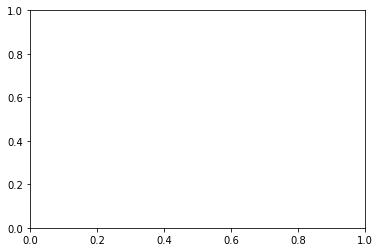

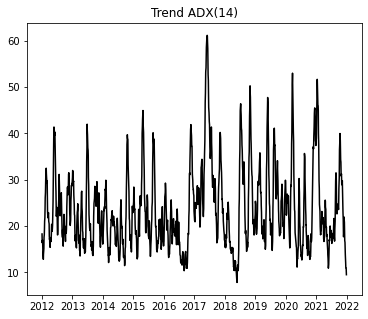

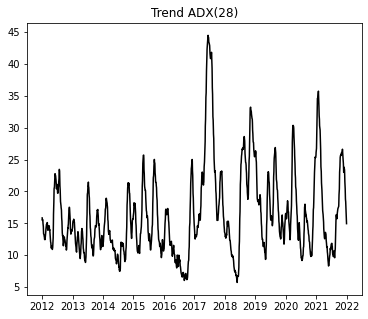

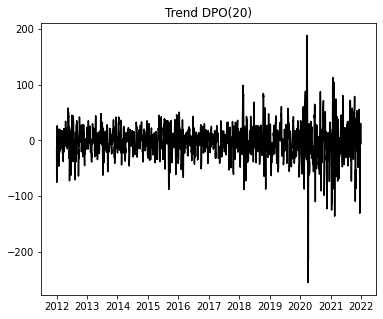

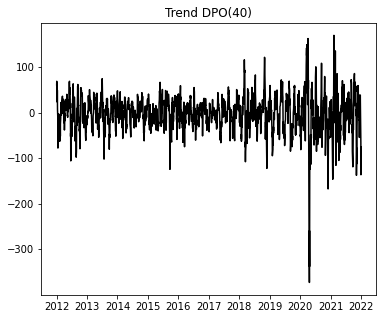

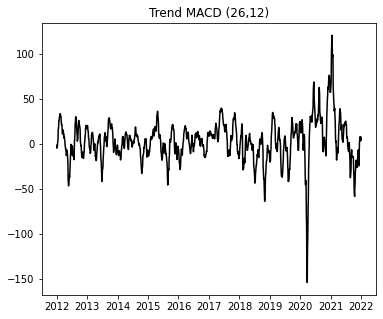

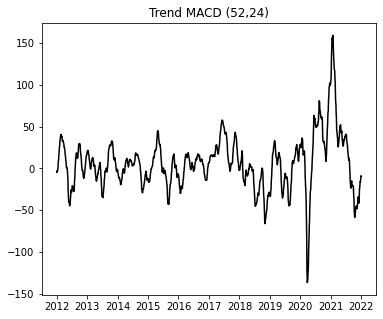

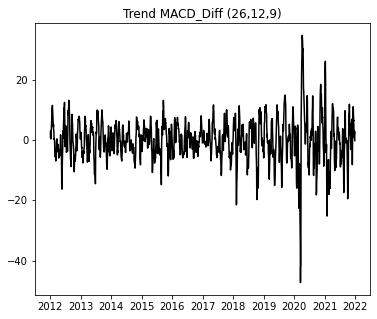

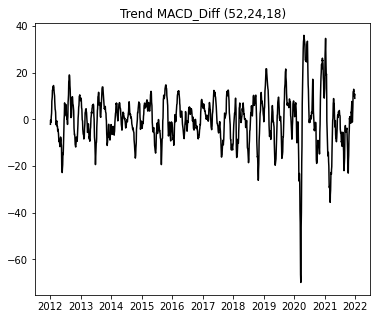

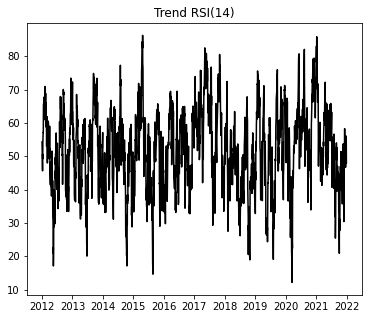

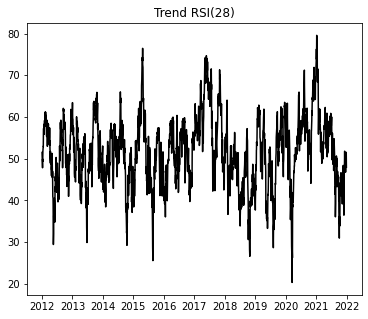

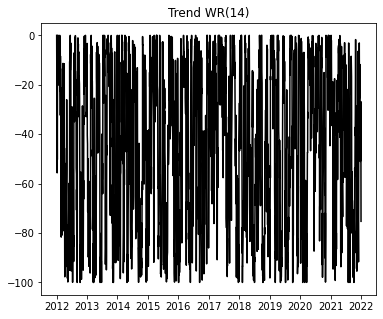

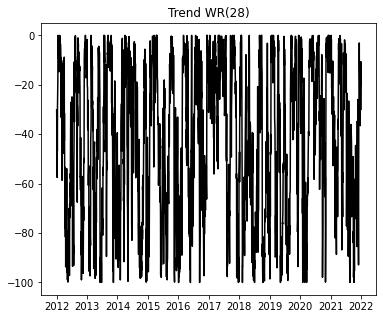

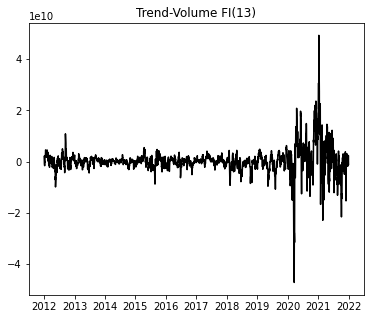

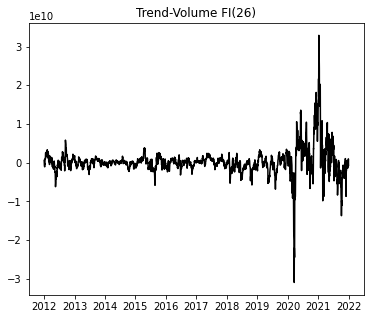

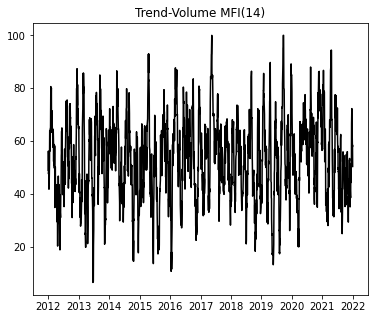

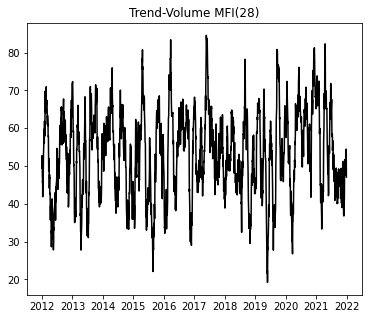

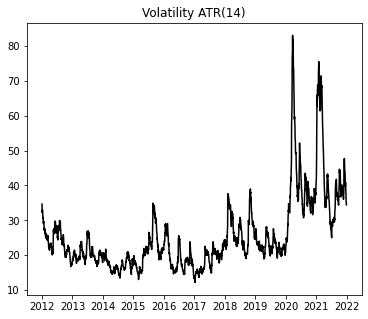

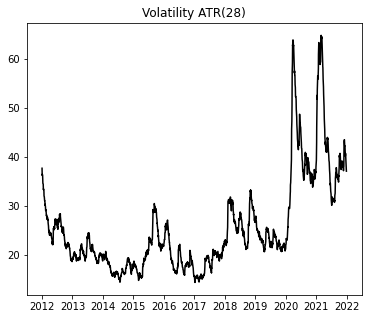

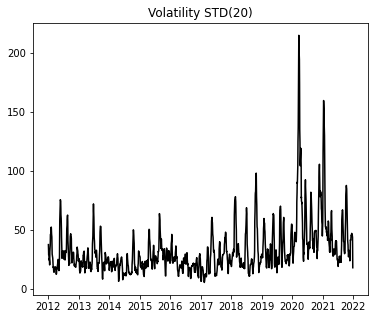

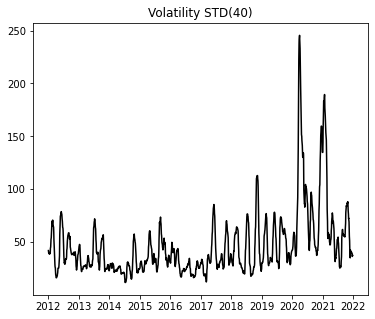

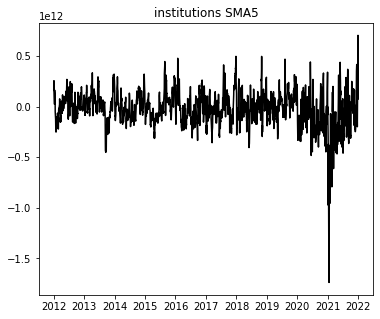

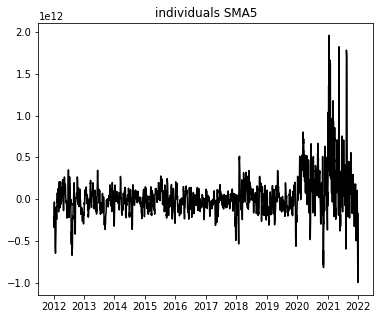

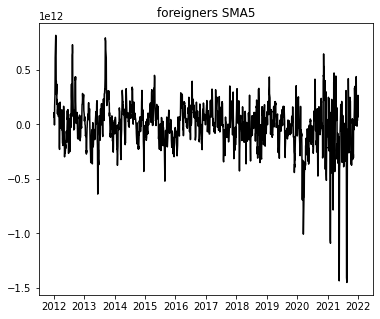

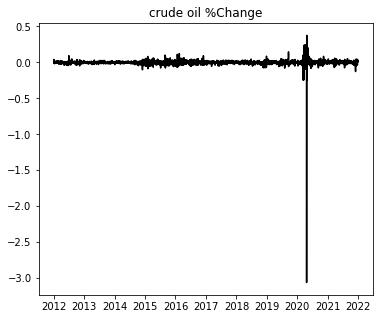

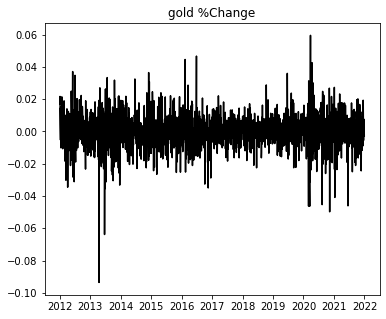

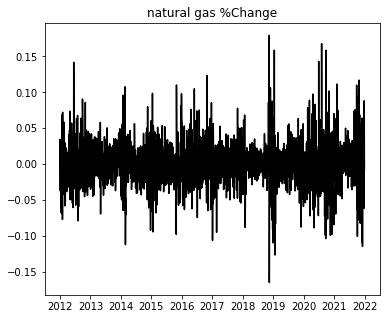

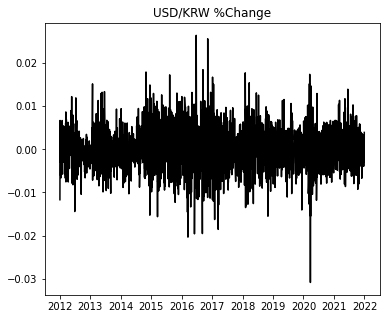

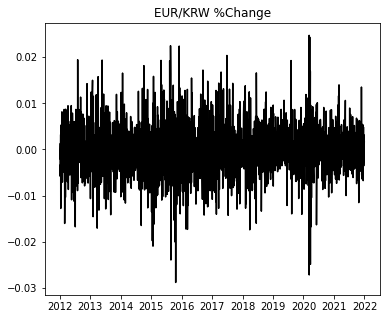

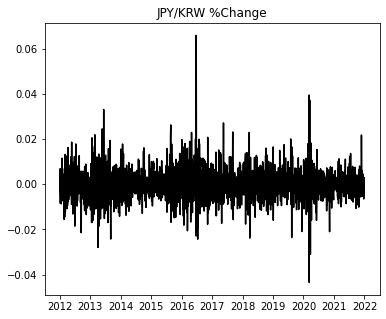

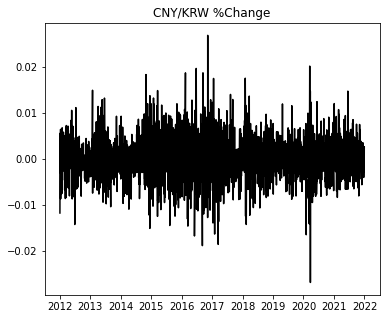

In [10]:
plt.subplots()
for i in X_.columns:
    plt.figure(figsize=(6,5))
    plt.title(i)
    plt.plot(X_[i], color='black')
    plt.xticks()
    plt.show()

# Feature Importance

In [11]:
from sklearn.preprocessing import StandardScaler

def feature_scaler(X):
    X_sc = StandardScaler().fit_transform(X)
    X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)
    return X_sc

def feature_scaler_test(X_train, X_test):
    scaler = StandardScaler()
    X_sc_train = scaler.fit_transform(X_train)
    X_sc_test = scaler.transform(X_test)
    X_sc_test = pd.DataFrame(X_sc_test, index=X_test.index, columns=X_test.columns)
    return X_sc_test

Clustering

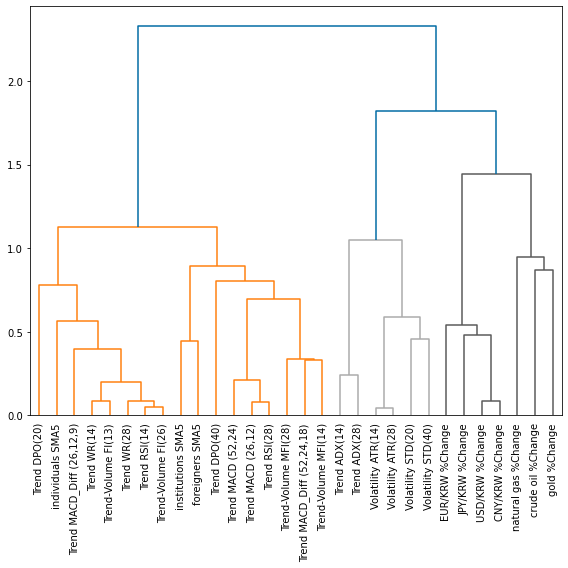

In [12]:
fig, ax = plt.subplots(1, figsize=(8, 8))
corr = spearmanr(X_['2012':'2019']).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_.columns, ax=ax, leaf_rotation=90
)
fig.tight_layout()
plt.savefig('c:img/hier_dendogram.png')
plt.show()

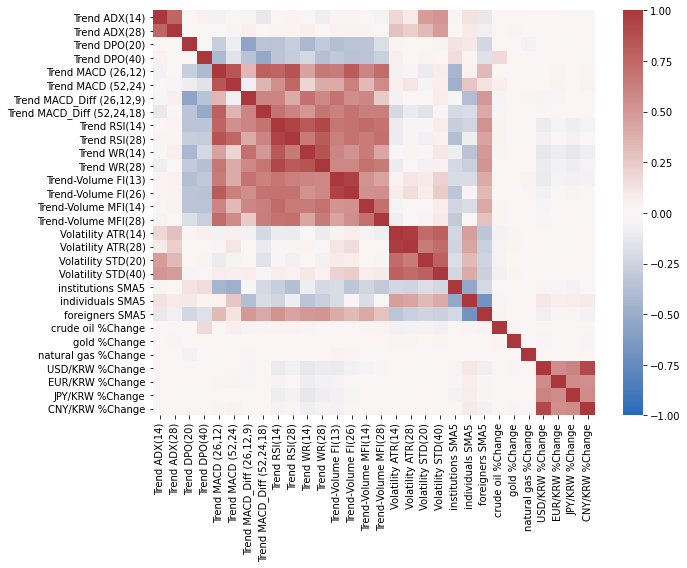

In [13]:
plt.figure(figsize=(10,8))
sns.heatmap(X_.corr(), vmin=-1,vmax=1, cmap='vlag')
plt.tight_layout()
plt.savefig('c:img/corr.png')
plt.show()

In [14]:
from collections import defaultdict
cluster_ids = hierarchy.fcluster(dist_linkage, 1.1, criterion="distance")
clusters_ = {i: X_.columns[np.where(cluster_ids == i)[0]].tolist() for i in np.unique(cluster_ids)}
#clusters = [clusters_[i] for i in range(1,1+len(clusters_))]

In [15]:
clusters_

{1: ['Trend DPO(20)',
  'Trend MACD_Diff (26,12,9)',
  'Trend RSI(14)',
  'Trend WR(14)',
  'Trend WR(28)',
  'Trend-Volume FI(13)',
  'Trend-Volume FI(26)',
  'individuals SMA5'],
 2: ['Trend DPO(40)',
  'Trend MACD (26,12)',
  'Trend MACD (52,24)',
  'Trend MACD_Diff (52,24,18)',
  'Trend RSI(28)',
  'Trend-Volume MFI(14)',
  'Trend-Volume MFI(28)',
  'institutions SMA5',
  'foreigners SMA5'],
 3: ['Trend ADX(14)',
  'Trend ADX(28)',
  'Volatility ATR(14)',
  'Volatility ATR(28)',
  'Volatility STD(20)',
  'Volatility STD(40)'],
 4: ['USD/KRW %Change',
  'EUR/KRW %Change',
  'JPY/KRW %Change',
  'CNY/KRW %Change'],
 5: ['crude oil %Change', 'gold %Change', 'natural gas %Change']}

In [16]:
def simple_train_test_split(X_,y_,start_date, split_date, end_date):
    tmp = pd.concat([X_,y_],axis=1).dropna()
    X = tmp.iloc[:,:-1]; y = tmp.iloc[:,-1].rename('y')
    X_train = X[start_date:split_date]; y_train = y[start_date:split_date]
    X_test = X[split_date:end_date]; y_test = y[split_date:end_date]; 
    return X_train, y_train, X_test, y_test

In [17]:
n_estimators = [20,50,100] # number of trees in the random forest
max_depth = [3,9,15] # maximum number of levels allowed in each decision tree

param_grid = {'n_estimators': n_estimators,
'max_depth': max_depth}
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
gcv = GridSearchCV(rf,param_grid=param_grid)
best_params = []
best_rf = []

price = market_df.close['2012':]
periods = [1,5,20]
y_list = [np.sign(np.sign(-price.diff(-y_))+1).rename('y_{}'.format(y_)) for y_ in periods]

for y_i in y_list:
    gcv = GridSearchCV(rf,param_grid=param_grid)
    tmp = pd.concat([X_,y_i],axis=1).dropna()
    X = tmp.iloc[:,:-1]; y = tmp.iloc[:,-1].rename('y')
    X = feature_scaler(X)
    gcv.fit(X, y)
    best_params.append(gcv.best_params_)
    best_rf.append(gcv.best_estimator_)

In [18]:
best_params

[{'max_depth': 3, 'n_estimators': 100},
 {'max_depth': 3, 'n_estimators': 100},
 {'max_depth': 3, 'n_estimators': 100}]

In [19]:
# SIMPLE TRAIN_TEST
rfy1=RandomForestClassifier(max_depth=3, n_estimators=100)
rfy5=RandomForestClassifier(max_depth=3, n_estimators=100)
rfy20=RandomForestClassifier(max_depth=15, n_estimators=50)

# Models
lr = LogisticRegression()
#rfy1=best_rf[0]
#rfy5=best_rf[1]
#rfy20=best_rf[2]
#rfy60=best_rf[3]
clf_list = [[lr,rfy1],[lr,rfy5],[lr,rfy20]]
estimators=['LR','RF']

#labeling
price = market_df.close['2012':]
periods = [1,5,20]
y_list = [np.sign(np.sign(-price.diff(-y_))+1).rename('y_{}'.format(y_)) for y_ in periods]

In [20]:
results_list=[]

for i in range(len(y_list)):
    y_i = y_list[i]
    X_train_, y_train, X_test_, y_test = simple_train_test_split(X_,y_i,'2012','2019','2022')
    X_train = feature_scaler(X_train_)
    X_test = feature_scaler_test(X_train_, X_test_)
    scores_list = []
    for clf in clf_list[i]:
        y_preds_ = []
        y_probs_ = []
        clf.fit(X_train, y_train)
        y_true = y_test
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]
        
        accs = accuracy_score(y_true, y_pred)
        f1=f1_score(y_true, y_pred)
        #prec=precision_score(y_true, y_pred)
        rocauc = roc_auc_score(y_true, y_prob)
        score = [accs, f1, rocauc]
        scores_list.append(score)
        
    results = pd.DataFrame(scores_list, columns=['accuracy','f1 score','roc auc score'],
                           index=estimators)
    results_list.append(results)

In [21]:
results_list

[    accuracy  f1 score  roc auc score
 LR  0.546463  0.555102       0.558837
 RF  0.604716  0.682981       0.599633,
     accuracy  f1 score  roc auc score
 LR  0.497920  0.492997       0.497775
 RF  0.629681  0.745472       0.610798,
     accuracy  f1 score  roc auc score
 LR  0.423024  0.405714       0.433421
 RF  0.675451  0.737079       0.734527]

In [22]:
results_df = pd.concat(results_list)
index_array = [np.sort(np.array(['$y_{001}$','$y_{005}$','$y_{020}$']*len(estimators))),np.array(results_df.index.values)]
results_df.index = index_array
results_df.round(4).to_excel('c:data/model_performance.xlsx')
results_df.round(4)

accuracy  f1 score  roc auc score
$y_{001}$ LR    0.5465    0.5551         0.5588
          RF    0.6047    0.6830         0.5996
$y_{005}$ LR    0.4979    0.4930         0.4978
          RF    0.6297    0.7455         0.6108
$y_{020}$ LR    0.4230    0.4057         0.4334
          RF    0.6755    0.7371         0.7345

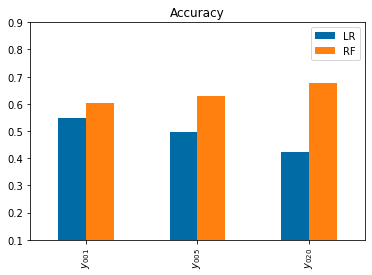

In [23]:
results_df.unstack()['accuracy'].plot(kind='bar')
plt.title('Accuracy')
plt.ylim(.1,.9)
plt.savefig('C:img/accuracy.png')

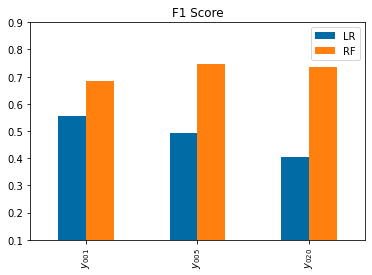

In [24]:
results_df.unstack()['f1 score'].plot(kind='bar')
plt.title('F1 Score')
plt.ylim(0.1,0.9)
plt.savefig('C:img/f1.png')

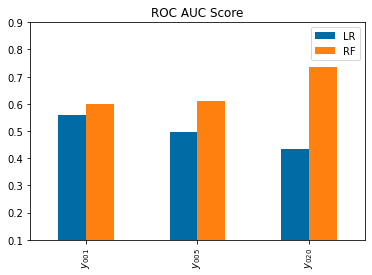

In [25]:
results_df.unstack()['roc auc score'].plot(kind='bar')
plt.title('ROC AUC Score')
plt.ylim(0.1,0.9)
plt.savefig('C:img/rocauc.png')

## Clustered Permutation Importance

aka. Mean Decrease Accuracy , Mean Decrease F1, Mean Decrease AUC

In [26]:
results_list=[]
importance_list_acc = []
importance_list_f1 = []
importance_list_auc = []

for i in range(len(y_list)):
    y_i = y_list[i]
    X_train_, y_train, X_test_, y_test = simple_train_test_split(X_,y_i,'2012','2018','2022')
    X_train = feature_scaler(X_train_)
    X_test = feature_scaler_test(X_train_, X_test_)
    scores_list = []
    importance_clf_acc = []
    importance_clf_f1 = []
    importance_clf_auc = []
    for clf in clf_list[i]:
        y_preds_ = []
        y_probs_ = []
        clf.fit(X_train, y_train)
        y_true = y_test
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]
        accs = accuracy_score(y_true, y_pred)
        f1=f1_score(y_true, y_pred)
        prec=precision_score(y_true, y_pred)
        rocauc = roc_auc_score(y_true, y_prob)
        score = [accs, f1, prec, rocauc]
        scores_list.append(score)
        result_imp_acc = clustered_permutation_importance(clf, X_test, y_test, clusters_, 'acc',10)
        result_imp_f1 = clustered_permutation_importance(clf, X_test, y_test, clusters_, 'f1',10)
        result_imp_auc = clustered_permutation_importance(clf, X_test, y_test, clusters_, 'auc',10)
        importance_clf_acc.append(result_imp_acc)
        importance_clf_f1.append(result_imp_f1)
        importance_clf_auc.append(result_imp_auc)
        
    results = pd.DataFrame(scores_list, columns=['accuracy','f1 score','precision score','roc auc score'],
                           index=estimators)
    results_list.append(results)
    importance_list_acc.append(importance_clf_acc)
    importance_list_f1.append(importance_clf_f1)
    importance_list_auc.append(importance_clf_auc)

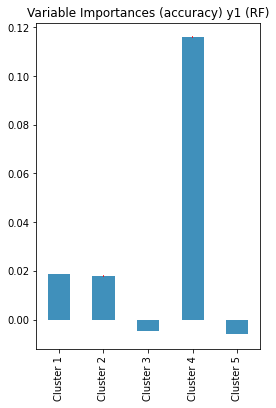

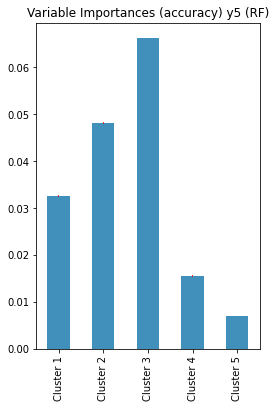

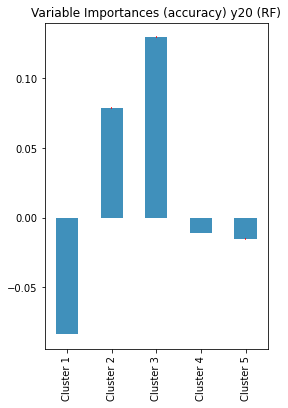

In [27]:
importance_df_acc = []
for j in range(len(y_list)):
    for i in range(len(estimators)-1):
        importance_df = importance_list_acc[j][i+1]
        plt.figure(figsize=(4, 6))
        #importance_df.sort_values('mean', ascending=True, inplace=True)
        importance_df['mean'].plot(kind='bar', alpha=0.75, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
        importance_df_acc.append(importance_df)
        plt.title("Variable Importances (accuracy) y{} ({})".format(periods[j], estimators[i+1]))
        plt.savefig('C:img/imp_y{}_{}.png'.format(periods[j], estimators[i+1]))

In [28]:
importance_df_acc

[               mean       std
 Cluster 1  0.018894  0.006023
 Cluster 2  0.017828  0.004439
 Cluster 3 -0.004577  0.001950
 Cluster 4  0.115865  0.009203
 Cluster 5 -0.005923  0.003521,
                mean       std
 Cluster 1  0.032589  0.003824
 Cluster 2  0.048031  0.005278
 Cluster 3  0.066177  0.001629
 Cluster 4  0.015613  0.002520
 Cluster 5  0.006904  0.001200,
                mean       std
 Cluster 1 -0.083425  0.008511
 Cluster 2  0.078515  0.008532
 Cluster 3  0.129262  0.008076
 Cluster 4 -0.010650  0.004809
 Cluster 5 -0.015528  0.002299]

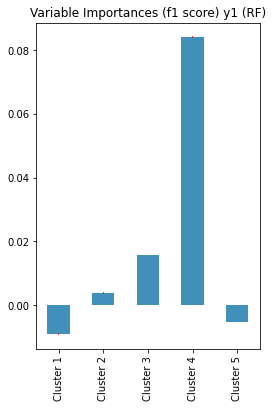

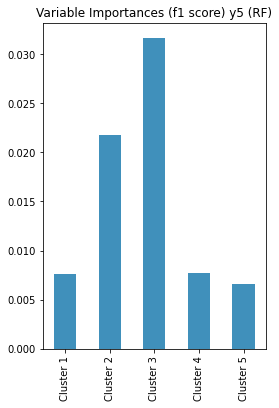

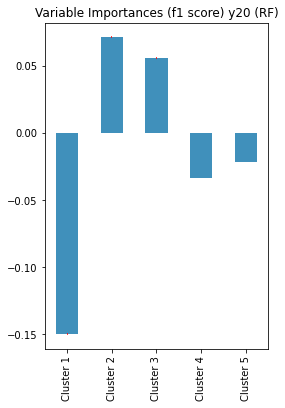

In [29]:
importance_df_f1=[]
for j in range(len(y_list)):
    for i in range(len(estimators)-1):
        importance_df = importance_list_f1[j][i+1]
        plt.figure(figsize=(4, 6))
        #importance_df.sort_values('mean', ascending=True, inplace=True)
        importance_df['mean'].plot(kind='bar', alpha=0.75, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
        importance_df_f1.append(importance_df)
        plt.title("Variable Importances (f1 score) y{} ({})".format(periods[j], estimators[i+1]))
        plt.savefig('C:img/imp_f1_y{}_{}.png'.format(periods[j], estimators[i+1]))

In [31]:
importance_df_f1

[               mean       std
 Cluster 1 -0.009118  0.006686
 Cluster 2  0.003714  0.006066
 Cluster 3  0.015820  0.004066
 Cluster 4  0.084021  0.007848
 Cluster 5 -0.005327  0.004608,
                mean       std
 Cluster 1  0.007639  0.005498
 Cluster 2  0.021738  0.001806
 Cluster 3  0.031624  0.002484
 Cluster 4  0.007706  0.003209
 Cluster 5  0.006551  0.001171,
                mean       std
 Cluster 1 -0.149741  0.014092
 Cluster 2  0.070912  0.006517
 Cluster 3  0.055786  0.009010
 Cluster 4 -0.033630  0.005606
 Cluster 5 -0.021945  0.004455]

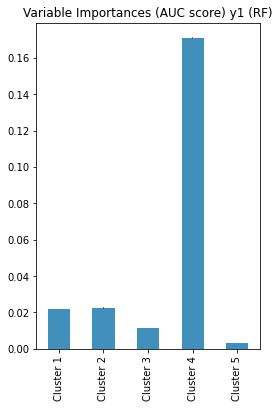

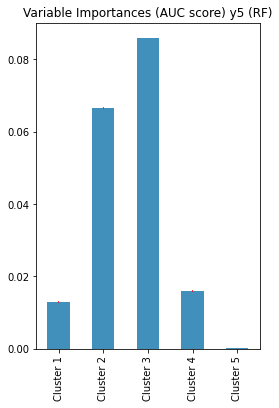

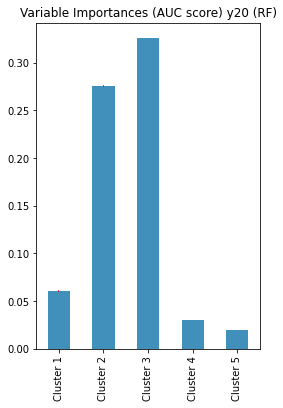

In [30]:
importance_df_auc=[]
for j in range(len(y_list)):
    for i in range(len(estimators)-1):
        importance_df = importance_list_auc[j][i+1]
        plt.figure(figsize=(4, 6))
        #importance_df.sort_values('mean', ascending=True, inplace=True)
        importance_df['mean'].plot(kind='bar', alpha=0.75, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
        importance_df_auc.append(importance_df)
        plt.title("Variable Importances (AUC score) y{} ({})".format(periods[j], estimators[i+1]))
        plt.savefig('C:img/imp_auc_y{}_{}.png'.format(periods[j], estimators[i+1]))

In [32]:
importance_df_auc

[               mean       std
 Cluster 1  0.021786  0.005876
 Cluster 2  0.022519  0.003420
 Cluster 3  0.011617  0.000987
 Cluster 4  0.170796  0.012437
 Cluster 5  0.003463  0.002442,
                mean       std
 Cluster 1  0.012948  0.004325
 Cluster 2  0.066661  0.005398
 Cluster 3  0.085870  0.004385
 Cluster 4  0.016106  0.002029
 Cluster 5  0.000175  0.001014,
                mean       std
 Cluster 1  0.060427  0.006906
 Cluster 2  0.275495  0.007257
 Cluster 3  0.325626  0.006636
 Cluster 4  0.030519  0.003862
 Cluster 5  0.019645  0.001909]